In [1]:
!pip install mlflow boto3 awscli

INFO: pip is looking at multiple versions of awscli to determine which version is compatible with other requirements. This could take a while.
  Using cached awscli-1.43.13-py3-none-any.whl.metadata (11 kB)
  Using cached awscli-1.43.10-py3-none-any.whl.metadata (11 kB)
INFO: pip is still looking at multiple versions of awscli to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
  Using cached botocore-1.35.99-py3-none-any.whl.metadata (5.7 kB)
   ---------------------------------------- 0.0/4.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/4.6 MB ? eta -:--:--
   -- ------------------------------------- 0.3/4.6 MB ? eta -:--:--
   ---- ----------------------------------- 0.5/4.6 MB 1.5 MB/s 

In [1]:
import mlflow
mlflow.set_tracking_uri("http://ec2-98-89-32-32.compute-1.amazonaws.com:5000/")

In [2]:
mlflow.set_experiment("Exp 2 - BoW vs TfIdf")

<Experiment: artifact_location='s3://mlflow-s3-bucket-25/118435417726069699', creation_time=1765642375192, experiment_id='118435417726069699', last_update_time=1765642375192, lifecycle_stage='active', name='Exp 2 - BoW vs TfIdf', tags={}>

In [3]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

In [4]:
df = pd.read_csv('reddit_preprocessing.csv').dropna(subset=['clean_comment'])
df.shape

(36662, 2)

2025/12/13 22:37:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run BoW_(1, 1)_RandomForest at: http://ec2-98-89-32-32.compute-1.amazonaws.com:5000/#/experiments/118435417726069699/runs/a2270278899d494f9dc995fac269f177.
2025/12/13 22:37:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://ec2-98-89-32-32.compute-1.amazonaws.com:5000/#/experiments/118435417726069699.


S3UploadFailedError: Failed to upload confusion_matrix.png to mlflow-s3-bucket-25/118435417726069699/a2270278899d494f9dc995fac269f177/artifacts/confusion_matrix.png: An error occurred (SignatureDoesNotMatch) when calling the PutObject operation: The request signature we calculated does not match the signature you provided. Check your key and signing method.

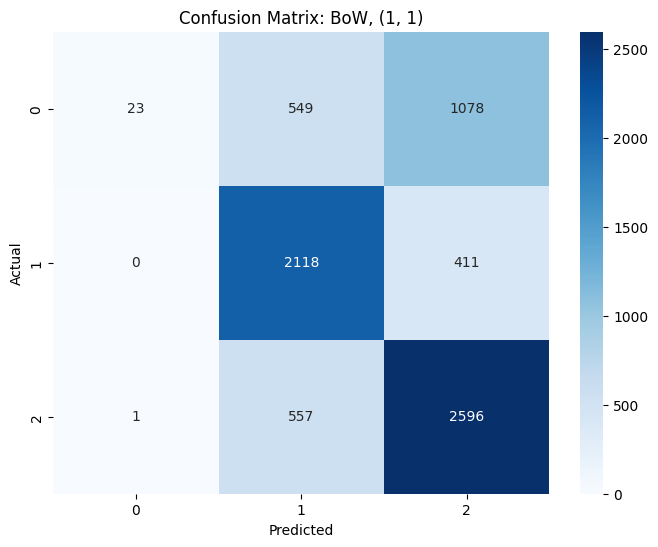

In [ ]:
# Run experiment
def run_experiment(vectorizer_type, ngram_range, vectorizer_max_features, vectorizer_name):
    # Vectorization
    if vectorizer_type == "BoW":
        vectorizer = CountVectorizer(
            ngram_range=ngram_range, max_features=vectorizer_max_features)
    else:
        vectorizer = TfidfVectorizer(
            ngram_range=ngram_range, max_features=vectorizer_max_features)

    X_train, X_test, y_train, y_test = train_test_split(
        df['clean_comment'], df['category'], test_size=0.2, random_state=42, stratify=df['category'])

    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)

    # Define and train a Random Forest model
    with mlflow.start_run() as run:
        # Set tags for the experiment and run
        mlflow.set_tag("mlflow.runName",
                       f"{vectorizer_name}_{ngram_range}_RandomForest")
        mlflow.set_tag("experiment_type", "feature_engineering")
        mlflow.set_tag("model_type", "RandomForestClassifier")

        # Add a description
        mlflow.set_tag(
            "description", f"RandomForest with {vectorizer_name}, ngram_range={ngram_range}, max_features={vectorizer_max_features}")

        # Log vectorizer parameters
        mlflow.log_param("vectorizer_type", vectorizer_type)
        mlflow.log_param("ngram_range", ngram_range)
        mlflow.log_param("vectorizer_max_features", vectorizer_max_features)

        # Log Random Forest parameters
        n_estimators = 200
        max_depth = 15

        mlflow.log_param("n_estimators", n_estimators)
        mlflow.log_param("max_depth", max_depth)

        # Initialize and train the model
        model = RandomForestClassifier(
            n_estimators=n_estimators, max_depth=max_depth, random_state=42)
        model.fit(X_train, y_train)

        # Make predictions and log metrics
        y_pred = model.predict(X_test)

        # Log accuracy
        accuracy = accuracy_score(y_test, y_pred)
        mlflow.log_metric("accuracy", accuracy)

        # Log classification report
        classification_rep = classification_report(
            y_test, y_pred, output_dict=True)
        for label, metrics in classification_rep.items():
            if isinstance(metrics, dict):
                for metric, value in metrics.items():
                    mlflow.log_metric(f"{label}_{metric}", value)

        # Log confusion matrix
        conf_matrix = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(f"Confusion Matrix: {vectorizer_name}, {ngram_range}")
        plt.savefig("confusion_matrix.png")
        mlflow.log_artifact("confusion_matrix.png")
        plt.close()

        # Log the model
        mlflow.sklearn.log_model(
            model, f"random_forest_model_{vectorizer_name}_{ngram_range}")


# Run experiments for BoW and TF-IDF with different n-grams
ngram_ranges = [(1, 1), (1, 2), (1, 3)]  # unigrams, bigrams, trigrams
max_features = 5000  # Example max feature size

for ngram_range in ngram_ranges:
    # BoW Experiments
    run_experiment("BoW", ngram_range, max_features, vectorizer_name="BoW")

    # TF-IDF Experiments
    run_experiment("TF-IDF", ngram_range, max_features,
                   vectorizer_name="TF-IDF")